# Text Classification with BERT in PyTorch
This notebook uses BERT base (which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.)to classifiy fake and real news

In [23]:
import pandas as pd
from transformers import BertTokenizer
import torch
import numpy as np
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv('/home/nadiera/Combined_Data.csv')
df

title  \
0     Rita Ora shows off her huge emerald engagement...   
1     ANC MP Sibusiso Kula breaks down crying in cou...   
2     Ten-year-old sexual assault victim taken to pl...   
3     Investor sentiment shifting in favour of emerg...   
4           One killed, two injured in Hilbrow shooting   
...                                                 ...   
1951  Eskom COO job to be scrapped after Oberholzer ...   
1952  UKZN graduation zulu dance motif, permitted pe...   
1953  ‘Rolling blackouts are due to historical under...   
1954  What is a White Life Worth? R3,000? A Cellphon...   
1955  Xenophobia: Presidents Paul Kagame, Felix Tshi...   

                                                   text  \
0     video player is loadingplay videoplaymutecurre...   
1     a murderaccused mp shed tears in court when he...   
2     newsa minor who was sexually assaulted by a li...   
3     investors are starting to weigh risks and oppo...   
4     one man was killed and two others injured last...   
...                                                 ...   
1951  when eskom coo jan oberholzer retires in april...   
1952  image screenshot of image from youtube videoby...   
1953  home eskom rolling blackouts rolling blackouts...   
1954  do white lives matter another white man was ki...   
1955   the world economic forum wef scheduled to beg...   

                                                    url        medium label  
0     https://www.news24.com/w24/selfcare/love/news/...        news24  real  
1     https://www.news24.com/news24/southafrica/news...        news24  real  
2     https://www.news24.com/citypress/news/ten-year...        news24  real  
3     https://www.news24.com/fin24/markets/investor-...        news24  real  
4     http://www.hinnews.com/za/metro-news/one-kille...   hinnews.com  fake  
...                                                 ...           ...   ...  
1951  https://www.news24.com/fin24/economy/eskom-coo...        news24  real  
1952  https://blackopinion.co.za/category/andilespeaks/  blackopinion  fake  
1953  https://www.sabcnews.com/sabcnews/rolling-blac...      sabcnews  real  
1954  https://sa-news.com/what-is-a-white-life-worth...       sa-news  fake  
1955  http://www.hinnews.com/za/national-news/xenoph...   hinnews.com  fake  

[1956 rows x 5 columns]

<AxesSubplot:xlabel='label'>

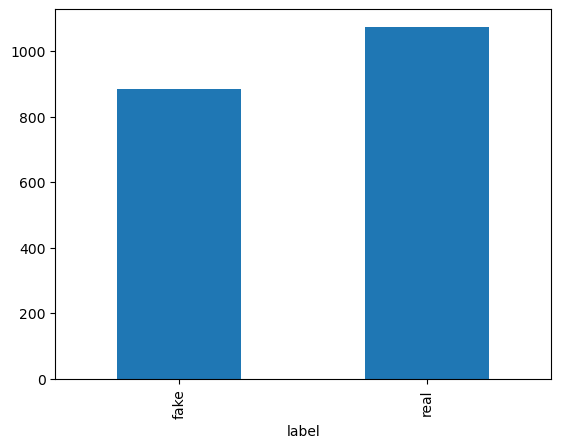

In [3]:
df.groupby(['label']).size().plot.bar()

### Preprocessing Data
 First we need to transform our text into the format that BERT expects by adding [CLS] and [SEP] tokens.This is easily  done with BertTokenizer class from Hugging Face.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])


tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [9]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


### Dataset Class

In [12]:


tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {"real": 0,"fake": 1}

        

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [13]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1564 196 196


### Model Building

In [15]:


class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### Training Loop

In [17]:


def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 782/782 [02:24<00:00,  5.42it/s]


Epochs: 1 | Train Loss:  0.486                 | Train Accuracy:  0.688                 | Val Loss:  0.234                 | Val Accuracy:  0.923


100%|█████████████████████████████████████████| 782/782 [02:24<00:00,  5.40it/s]


Epochs: 2 | Train Loss:  0.177                 | Train Accuracy:  0.932                 | Val Loss:  0.138                 | Val Accuracy:  0.959


100%|█████████████████████████████████████████| 782/782 [02:24<00:00,  5.42it/s]


Epochs: 3 | Train Loss:  0.097                 | Train Accuracy:  0.972                 | Val Loss:  0.116                 | Val Accuracy:  0.944


100%|█████████████████████████████████████████| 782/782 [02:24<00:00,  5.42it/s]


Epochs: 4 | Train Loss:  0.053                 | Train Accuracy:  0.991                 | Val Loss:  0.081                 | Val Accuracy:  0.959


100%|█████████████████████████████████████████| 782/782 [02:24<00:00,  5.41it/s]


Epochs: 5 | Train Loss:  0.030                 | Train Accuracy:  0.999                 | Val Loss:  0.064                 | Val Accuracy:  0.964


### Evaluate Model on Test Data

In [29]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.944


In [30]:
# # Plot confusion matrix.
# fig, ax = plt.subplots(figsize=(8, 8))
# cm = confusion_matrix(y_true=test_label, y_pred=total_acc_test, labels=range(len(labels)), normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
# disp.plot(ax=ax)

In [31]:
from sklearn.metrics import confusion_matrix

def evaluate(model, test_data):
    # ...

    all_labels = []
    all_preds = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            # ...

            # Collecting predictions and true labels
            all_labels.extend(test_label.cpu().numpy())
            all_preds.extend(output.argmax(dim=1).cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

# Evaluate and print confusion matrix
cm = evaluate(model, df_test)
print(cm)


NameError: name 'test_dataloader' is not defined